# Testing Navier-Stokes with a body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a cylinder

In [3]:
nx = 202; ny = 102;
Re = 200
U = 1.0
U∞ = (U,0.0)
Lx = 2.0;
Δx = Lx/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
q = Edges(Primal,w₀);

Set up points on the cylinder

In [4]:
n = 100;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ)
yb = 1.0 + R*sin.(θ)
ds = (2π/n)*R;
X = VectorData(xb[1:n],yb[1:n]);
f = VectorData(X);

In [5]:
regop = Regularize(X,Δx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(regop,f,q);
regopfilter = Regularize(X,Δx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(regopfilter,f,q);
Ẽmat = InterpolationMatrix(regopfilter,q,f);

In [6]:
B₂(w::Nodes) = -(Emat*(Curl()*(sys.L\w)))

B₂ (generic function with 1 method)

In [7]:
B₁ᵀ(f::VectorData) = Curl()*(Hmat*f)

B₁ᵀ (generic function with 1 method)

In [8]:
P(f::VectorData) = Ẽmat*(H̃mat*f)

P (generic function with 1 method)

In [9]:
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞)

Navier-Stokes system on a grid of size 202 x 102

In [10]:
function r₂(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY}
    f = VectorData(X)
    fill!(f.u,-U∞[1])
    fill!(f.v,-U∞[2])
    return f
end

r₂ (generic function with 1 method)

In [11]:
ifherk = IFHERK(w₀,f,sys.Δt,
                (t,w) -> Systems.plan_intfact(t,w,sys),
                (B₁ᵀ, B₂),
                ((w,t) -> Systems.r₁(w,t,sys),
                 (w,t) -> r₂(w,t)),rk=TimeMarching.RK31,conditioner=P)

Order-3 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{100}
   Time step size 0.01


In [16]:
t = 0.0
w₀ .= 0.0
w = deepcopy(w₀)
tf = 0.1
T = 0:Δt:tf;

In [19]:
@time t, w, f = ifherk(t,w)

  0.511361 seconds (663.67 k allocations: 97.057 MiB, 4.32% gc time)


(0.03, Whirl.Fields.Dual nodes in a (nx = 202, ny = 102) cell grid
  Number of Whirl.Fields.Dual nodes: (nx = 202, ny = 102), 100 points of vector-valued data
)

In [65]:
@time for ti in T
    t, w = ifherk(t,w)
end
println(t)

  5.166304 seconds (6.23 M allocations: 925.635 MiB, 3.81% gc time)
0.4400000000000002


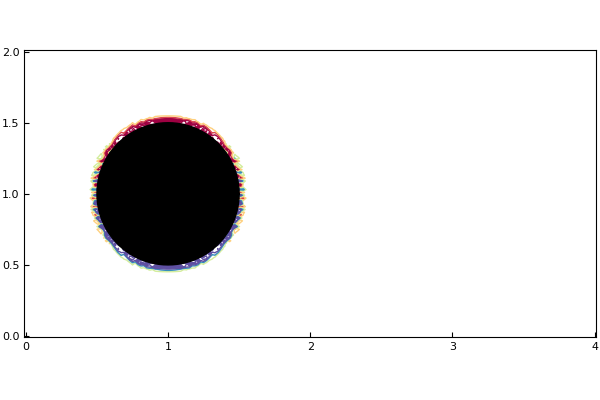

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [14]:
xg,yg = coordinates(w,dx=Δx)
plot(xg,yg,w,clim=(-0.5,0.5))
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=1,linecolor=:black)

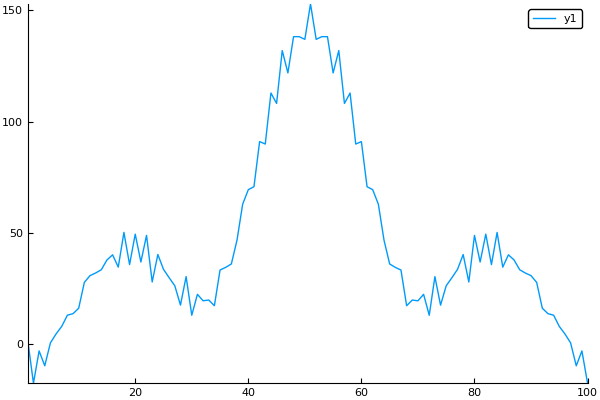

In [20]:
plot(f.u)